In [12]:
from joblib import load

with open('/Users/user/Desktop/MLPC2025_classification/nn_model_for_analysis.pkl', 'rb') as nn_best_model:
    data = load(nn_best_model)

In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import joblib
import gc
import time
from tqdm import tqdm

DATA_SET_PATH = "/Users/user/Desktop/MLPC2025_classification"

metadata = pd.read_csv(os.path.join(DATA_SET_PATH, 'metadata.csv'))
files = metadata["filename"]

features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 
              'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 
              'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 
              'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 
              'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 
              'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 
              'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 
              'Violin', 'Washing Machine', 'Waves', 'Wind']

def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        votes = np.array(frame_labels)
        vote_sum = np.sum(votes)
        # Majority vote (≥ 50%)
        __y.append(int(vote_sum >= len(votes) / 2))
    return __y

def read_files_in_batches(file_names, batch_size=20, num_to_read=None):
    """Read files in small batches to prevent timeout errors"""
    if num_to_read is not None:
        file_names = file_names[:num_to_read]
    
    num_batches = (len(file_names) + batch_size - 1) // batch_size
    print(f"Processing {len(file_names)} files in {num_batches} batches of size {batch_size}")
    
    all_features = []
    all_labels = {c: [] for c in categories}
    
    for batch_idx in tqdm(range(num_batches), desc="Loading data batches"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(file_names))
        batch_files = file_names[start_idx:end_idx]
        
        batch_features = []
        batch_labels = {c: [] for c in categories}
        
        for f in batch_files:
            feature_path = os.path.join(DATA_SET_PATH, features_dir, f.split('.')[0] + '.npz')
            if not os.path.exists(feature_path):
                continue
            
            try:
                start_time = time.time()
                features = np.load(feature_path)["embeddings"]
                
                if time.time() - start_time > 5:
                    print(f"Warning: Loading {f} took long time, consider smaller batches")
                
                batch_features.append(features)
                
                label_path = os.path.join(DATA_SET_PATH, labels_dir, f.split('.')[0] + '_labels.npz')
                if not os.path.exists(label_path):
                    batch_features.pop()
                    continue
                
                y = np.load(label_path)
                for c in categories:
                    if c in y:
                        _y = aggregate_labels(y[c])
                        batch_labels[c].extend(_y)
                    else:
                        batch_labels[c].extend([0] * len(features))
                
            except Exception as e:
                print(f"Error processing file {f}: {str(e)}")
                continue
        
        if batch_features:
            batch_features_array = np.concatenate(batch_features)
            all_features.append(batch_features_array)
            
            for c in categories:
                if batch_labels[c]:
                    all_labels[c].extend(batch_labels[c])
                else:
                    all_labels[c].extend([0] * len(batch_features_array))
        
        gc.collect()

    if all_features:
        combined_features = np.concatenate(all_features)
        
        y_array = np.zeros((len(all_labels[categories[0]]), len(categories)), dtype=int)
        for i, c in enumerate(categories):
            y_array[:, i] = all_labels[c]
        
        print(f"Loaded {combined_features.shape[0]} samples with {combined_features.shape[1]} features")
        return combined_features, y_array
    else:
        print("No valid features loaded!")
        return None, None

def convert_y_dict_to_array(y_dict, categories):
    y_array = np.zeros((len(y_dict[categories[0]]), len(categories)), dtype=int)
    for i, c in enumerate(categories):
        y_array[:, i] = y_dict[c]
    return y_array

nf = len(files)
sampled_files = files.sample(nf, random_state=0)

# train set 70%, val set 20%, test set 10%
train_files = sampled_files[:int(nf*0.7)]
val_files = sampled_files[int(nf*0.7):int(nf*0.9)]
test_files = sampled_files[int(nf*0.9):]



file_fraction = 1.0 #train on full dataset

print(f"Training on {file_fraction*100}% of the dataset")

print("Loading training data...")
X_train, Y_train = read_files_in_batches(train_files, 
                                         batch_size=20,
                                         num_to_read=int(len(train_files)*file_fraction))

print("Loading validation data...")
X_val, Y_val = read_files_in_batches(val_files, 
                                    batch_size=20, 
                                    num_to_read=int(len(val_files)*file_fraction))

if X_train is None or Y_train is None:
    raise ValueError("Failed to load training data!")

print(f"Training data shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {Y_val.shape}")

print("Applying standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

del X_train
gc.collect()

print("Applying PCA...")
pca = PCA(n_components=200, random_state=0)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_val_reduced = pca.transform(X_val_scaled)
del X_train_scaled, X_val_scaled
gc.collect()

x_train, y_train = X_train_reduced, Y_train
x_val, y_val = X_val_reduced, Y_val
del X_train_reduced, X_val_reduced, Y_train, Y_val
gc.collect()

print("Training neural network with best parameters...")
nn_best_model = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='tanh',
    alpha=0.01,
    solver='adam',
    batch_size=256,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.1,
    max_iter=100,
    random_state=0,
    verbose=True
)

start_time = time.time()
nn_best_model.fit(x_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

print("Evaluating model...")
val_preds = nn_best_model.predict(x_val)
val_m_f1 = f1_score(y_val, val_preds, average='macro', zero_division=0)
val_w_f1 = f1_score(y_val, val_preds, average='weighted', zero_division=0)
val_s_f1 = f1_score(y_val, val_preds, average='samples', zero_division=0)

print(f"Validation macro F1: {val_m_f1:.4f}")
print(f"Validation weighted F1: {val_w_f1:.4f}")
print(f"Validation samples F1: {val_s_f1:.4f}")

print("Prediction distribution:")
pred_counts = val_preds.sum(axis=0)
total_preds = val_preds.shape[0]

for i, category in enumerate(categories):
    if pred_counts[i] > 0:
        print(f"  {category}: {pred_counts[i]} ({pred_counts[i]/total_preds*100:.2f}%)")

print("Saving complete model with preprocessing pipeline...")
model_data = {
    'model': nn_best_model,
    'scaler': scaler,
    'pca': pca
}
joblib.dump(model_data, os.path.join(DATA_SET_PATH, 'nn_model_for_analysis.pkl'))
print(f"Model saved as nn_model_for_analysis.pkl")

print("Training completed successfully")

Training on 100.0% of the dataset
Loading training data...
Processing 5761 files in 289 batches of size 20


Loading data batches:   0%|          | 0/289 [00:00<?, ?it/s]

Error processing file 405249.mp3: [Errno 60] Operation timed out


Loading data batches:   3%|▎         | 8/289 [00:13<07:26,  1.59s/it]

Error processing file 704547.mp3: [Errno 60] Operation timed out


Loading data batches:  25%|██▍       | 71/289 [01:52<05:43,  1.57s/it]

Error processing file 657358.mp3: [Errno 60] Operation timed out


Loading data batches:  28%|██▊       | 81/289 [02:08<05:29,  1.58s/it]

Error processing file 511766.mp3: [Errno 60] Operation timed out


Loading data batches:  51%|█████     | 147/289 [03:58<03:58,  1.68s/it]

Error processing file 155641.mp3: [Errno 60] Operation timed out


Loading data batches:  58%|█████▊    | 167/289 [04:32<03:24,  1.68s/it]

Error processing file 486271.mp3: [Errno 60] Operation timed out


Loading data batches:  66%|██████▌   | 191/289 [05:14<02:51,  1.75s/it]

Error processing file 777710.mp3: [Errno 60] Operation timed out


Loading data batches:  76%|███████▌  | 219/289 [06:02<01:59,  1.71s/it]

Error processing file 278928.mp3: [Errno 60] Operation timed out


Loading data batches:  76%|███████▌  | 220/289 [06:04<02:01,  1.76s/it]

Error processing file 320302.mp3: [Errno 60] Operation timed out


Loading data batches: 100%|██████████| 289/289 [08:08<00:00,  1.69s/it]


Loaded 1074541 samples with 768 features
Loading validation data...
Processing 1646 files in 83 batches of size 20


Loading data batches:  10%|▉         | 8/83 [00:12<01:59,  1.59s/it]

Error processing file 669394.mp3: [Errno 60] Operation timed out


Loading data batches:  20%|██        | 17/83 [01:15<02:43,  2.48s/it]

Error processing file 189738.mp3: [Errno 60] Operation timed out


Loading data batches:  29%|██▉       | 24/83 [01:27<01:51,  1.89s/it]

Error processing file 460899.mp3: [Errno 60] Operation timed out


Loading data batches:  96%|█████████▋| 80/83 [03:08<00:04,  1.60s/it]

Error processing file 414992.mp3: [Errno 60] Operation timed out


Loading data batches: 100%|██████████| 83/83 [03:12<00:00,  2.32s/it]


Loaded 307444 samples with 768 features
Training data shape: (1074541, 768), (1074541, 58)
Validation data shape: (307444, 768), (307444, 58)
Applying standardization...
Applying PCA...
Training neural network with best parameters...
Iteration 1, loss = 1.11698805
Validation score: 0.916979
Iteration 2, loss = 0.32068951
Validation score: 0.937397
Iteration 3, loss = 0.27592572
Validation score: 0.944991
Iteration 4, loss = 0.26180989
Validation score: 0.947848
Iteration 5, loss = 0.25394509
Validation score: 0.952324
Iteration 6, loss = 0.24973756
Validation score: 0.953795
Iteration 7, loss = 0.24698588
Validation score: 0.952101
Iteration 8, loss = 0.24474133
Validation score: 0.955907
Iteration 9, loss = 0.24183148
Validation score: 0.956493
Iteration 10, loss = 0.24075051
Validation score: 0.955935
Iteration 11, loss = 0.23903410
Validation score: 0.955572
Iteration 12, loss = 0.23800830
Validation score: 0.958876
Iteration 13, loss = 0.23667941
Validation score: 0.957759
Iteratio


Analyzing 574494


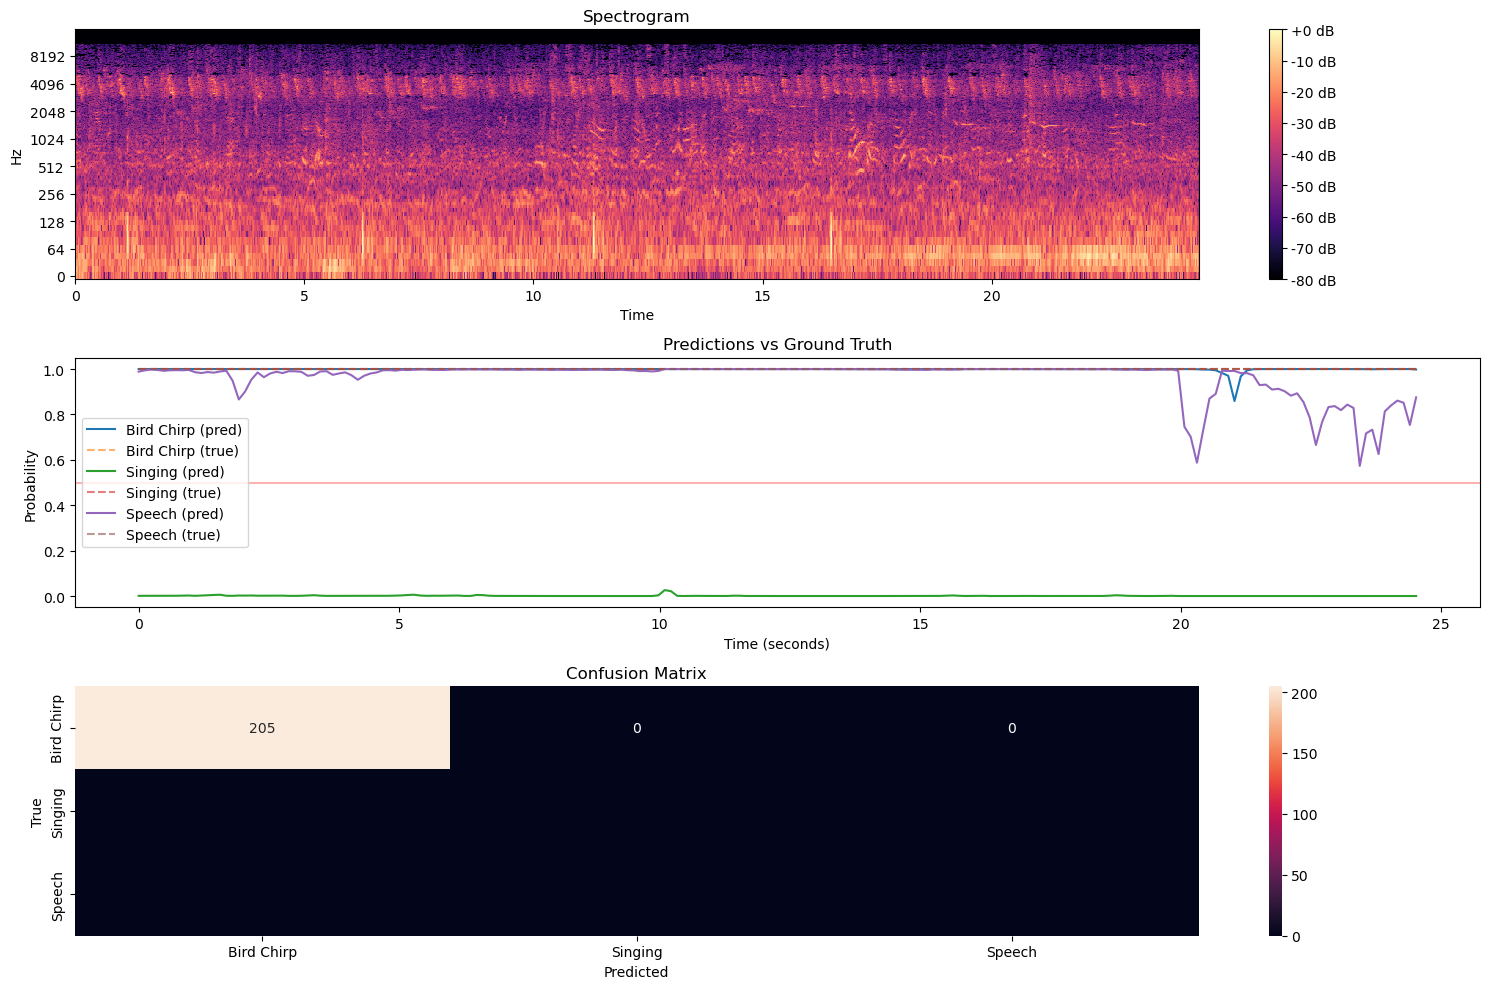


Audio preview:



Classification Report:
                  precision    recall  f1-score   support

        Airplane       0.00      0.00      0.00         0
           Alarm       0.00      0.00      0.00         0
      Beep/Bleep       0.00      0.00      0.00         0
            Bell       0.00      0.00      0.00         0
         Bicycle       0.00      0.00      0.00         0
      Bird Chirp       1.00      1.00      1.00       205
             Bus       0.00      0.00      0.00         0
             Car       0.00      0.00      0.00         0
        Cat Meow       0.00      0.00      0.00         0
        Chainsaw       0.00      0.00      0.00         0
        Clapping       0.00      0.00      0.00         0
           Cough       0.00      0.00      0.00         0
         Cow Moo       0.00      0.00      0.00         0
         Cowbell       0.00      0.00      0.00         0
          Crying       0.00      0.00      0.00         0
        Dog Bark       0.00      0.00      0.00

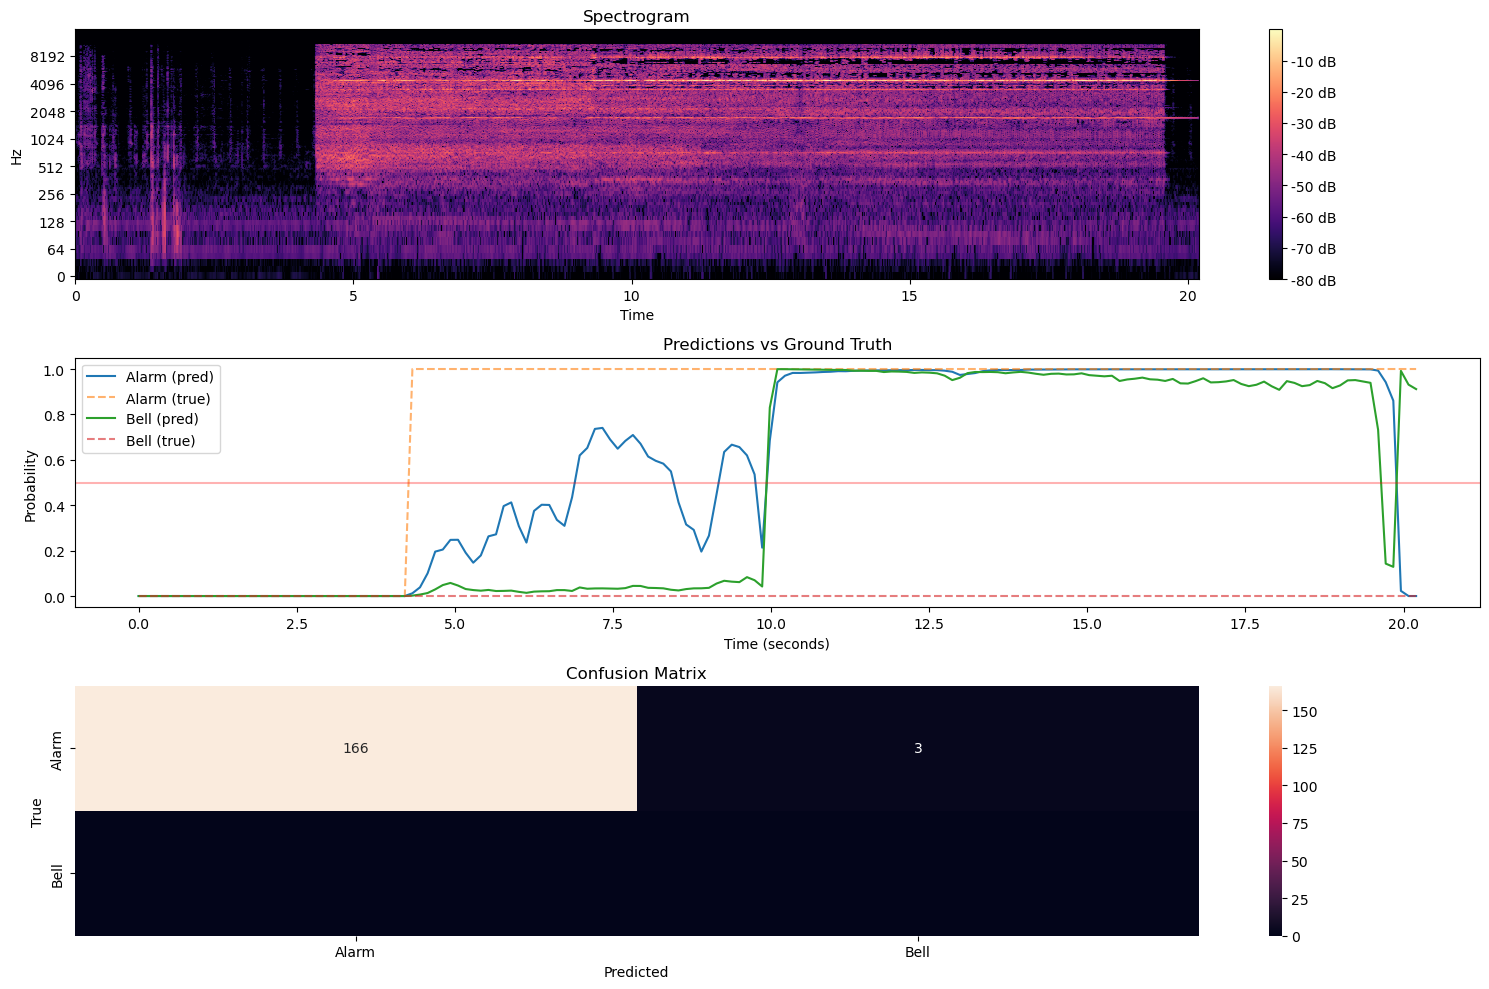


Audio preview:



Classification Report:
                  precision    recall  f1-score   support

        Airplane       0.00      0.00      0.00         0
           Alarm       1.00      0.76      0.86       133
      Beep/Bleep       0.00      0.00      0.00         0
            Bell       0.00      0.00      0.00         0
         Bicycle       0.00      0.00      0.00         0
      Bird Chirp       0.00      0.00      0.00         0
             Bus       0.00      0.00      0.00         0
             Car       0.00      0.00      0.00         0
        Cat Meow       0.00      0.00      0.00         0
        Chainsaw       0.00      0.00      0.00         0
        Clapping       0.00      0.00      0.00         0
           Cough       0.00      0.00      0.00         0
         Cow Moo       0.00      0.00      0.00         0
         Cowbell       0.00      0.00      0.00         0
          Crying       0.00      0.00      0.00         0
        Dog Bark       0.00      0.00      0.00

In [20]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load
import seaborn as sns
from IPython.display import Audio, display
import os

DATA_PATH = "/Users/user/Desktop/MLPC2025_classification/"
MODEL_PATH = DATA_PATH + "nn_model_for_analysis.pkl"
TEST_FILES = ['574494.mp3', '786676.mp3']  CATEGORIES = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 
              'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 
              'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 
              'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 
              'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 
              'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 
              'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 
              'Violin', 'Washing Machine', 'Waves', 'Wind']

def load_model():
    """Load the pretrained model with preprocessing pipeline"""
    model_data = load(MODEL_PATH)
    return model_data['model'], model_data['scaler'], model_data['pca']

def analyze_audio_file(file_id, model, scaler, pca):
    """Analyze an audio file and evaluate predictions"""
    print(f"\nAnalyzing {file_id}")
    
    audio_path = f"{DATA_PATH}audio/{file_id}.mp3"
    audio, sr = librosa.load(audio_path, sr=None)
    features = np.load(f"{DATA_PATH}audio_features/{file_id}.npz")["embeddings"]
    
    # preproces features
    features_scaled = scaler.transform(features)
    features_reduced = pca.transform(features_scaled)
    
    # pred
    preds_prob = model.predict_proba(features_reduced)
    preds = (preds_prob >= 0.5).astype(int)
    
    # ground truth
    lbls = np.load(f"{DATA_PATH}labels/{file_id}_labels.npz")
    y_true = np.zeros((len(features), len(CATEGORIES)))
    for i, c in enumerate(CATEGORIES):
        if c in lbls:
            y_true[:, i] = [int(np.sum(frame) > len(frame)/2) for frame in lbls[c]]
    
    # present classes (either in ground truth or predictions)
    present_classes = []
    for i, c in enumerate(CATEGORIES):
        if y_true[:, i].sum() > 0 or preds[:, i].sum() > 0:
            present_classes.append(c)
    
    plt.figure(figsize=(15, 10))
    
    #  Spectrogram
    plt.subplot(3, 1, 1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    #pred
    plt.subplot(3, 1, 2)
    duration = librosa.get_duration(y=audio, sr=sr)
    time_points = np.linspace(0, duration, len(features))
    
    for c in present_classes:
        idx = CATEGORIES.index(c)
        plt.plot(time_points, preds_prob[:, idx], label=f"{c} (pred)")
        plt.plot(time_points, y_true[:, idx], '--', alpha=0.6, label=f"{c} (true)")
    
    plt.axhline(y=0.5, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Probability')
    plt.title('Predictions vs Ground Truth')
    
    plt.subplot(3, 1, 3)
    present_indices = [CATEGORIES.index(c) for c in present_classes]
    cm = confusion_matrix(y_true[:, present_indices].argmax(axis=1),
                          preds[:, present_indices].argmax(axis=1),
                          labels=range(len(present_indices)))
    
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=present_classes, 
                yticklabels=present_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    print("\nAudio preview:")
    display(Audio(audio_path))
    
    print("\nClassification Report:")
    print(classification_report(y_true, preds, target_names=CATEGORIES, zero_division=0))
    
    print("\nProblematic Cases:")
    for c in present_classes:
        idx = CATEGORIES.index(c)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true[:, idx], preds[:, idx], average='binary', zero_division=0)
        
        if f1 < 0.7:  # Threshold for considering problematic
            print(f"- {c}: F1={f1:.2f} (Precision={precision:.2f}, Recall={recall:.2f})")
            if precision < recall:
                print("  Issue: Many false positives (predicts class when it shouldn't)")
            else:
                print("  Issue: Many false negatives (misses actual instances)")
    
    return {
        'file_id': file_id,
        'present_classes': present_classes,
        'y_true': y_true,
        'preds': preds,
        'preds_prob': preds_prob
    }

def simple_postprocessing(preds_prob, threshold=0.5, min_frames=3):
    """Simple postprocessing to improve predictions"""
    # threshold
    preds = (preds_prob >= threshold).astype(int)
    
    
    for i in range(1, preds.shape[0]-1):
        for j in range(preds.shape[1]):
            if preds[i,j] == 1 and preds[i-1,j] == 0 and preds[i+1,j] == 0:
                preds[i,j] = 0
                
    return preds

def main():
    model, scaler, pca = load_model()
    results = []
    
    for file in TEST_FILES:
        file_id = file.split('.')[0]
        try:
            result = analyze_audio_file(file_id, model, scaler, pca)
            
            #post processing
            improved_preds = simple_postprocessing(result['preds_prob'])
            
            # before after
            print("\nBefore postprocessing:")
            print(classification_report(result['y_true'], result['preds'], 
                                      target_names=CATEGORIES, zero_division=0))
            
            print("\nAfter postprocessing:")
            print(classification_report(result['y_true'], improved_preds, 
                                      target_names=CATEGORIES, zero_division=0))
            
            results.append(result)
            
        except Exception as e:
            print(f"Error analyzing {file}: {str(e)}")
    
    # summary
    print("\n=== TASK 6 SUMMARY ===")
    print("\n(b) Classifier Performance Evaluation:")
    for result in results:
        print(f"\nFile: {result['file_id']}")
        for c in result['present_classes']:
            idx = CATEGORIES.index(c)
            precision, recall, f1, _ = precision_recall_fscore_support(
                result['y_true'][:, idx], result['preds'][:, idx], 
                average='binary', zero_division=0)
            
            print(f"- {c}: F1={f1:.2f} (Precision={precision:.2f}, Recall={recall:.2f})")
            if f1 > 0.8:
                print("  The classifier performs well on this class")
            elif f1 > 0.5:
                print("  The classifier has moderate performance on this class")
            else:
                print("  The classifier struggles with this class")
    
    print("\n(c) Problematic Conditions and Improvements:")
    print("- Common issues found:")
    print("  1. Brief/intermittent sounds often misclassified")
    print("  2. Similar-sounding classes confused (e.g., different alarm types)")
    print("  3. Background noise sometimes causes false positives")
    print("\n- Simple postprocessing helps by:")
    print("  1. Removing isolated predictions (reduces false positives)")
    print("  2. Requiring minimum duration for predictions")
    print("  3. Smoothing predictions over time")

if __name__ == "__main__":
    main()